In [1]:
# Imports and setup.
from nerf_grasping import grasp_opt, grasp_utils, mesh_utils
import lietorch
import nerf
import numpy as np
import os
import pypoisson
import scipy.spatial
import torch
import trimesh

from matplotlib import pyplot as plt

# nerf_shared requires us to default to cuda tensors.
torch.set_default_tensor_type(torch.cuda.FloatTensor)

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
T = np.eye(4)
pose = np.array([
    1.2108e-04, 5.0580e-05, 2.7067e-03, -6.7140e-03, -9.7980e-03, 4.5278e-05,
    9.9993e-01
])

R = scipy.spatial.transform.Rotation.from_euler('Y', [-np.pi / 2]).as_matrix()
R = R @ scipy.spatial.transform.Rotation.from_euler('X',
                                                    [-np.pi / 2]).as_matrix()
T[:3, :3] = R
T[:3, -1] = pose[:3]

print(R @ np.eye(3))

gt_mesh = trimesh.load('assets/objects/meshes/banana/textured.obj',
                       force='mesh')
gt_mesh.apply_transform(trimesh.transformations.translation_matrix(pose[:3]))
gt_mesh.apply_transform(T)
# gt_mesh.show()

[[[ 2.22044605e-16  1.00000000e+00 -2.22044605e-16]
  [ 0.00000000e+00  2.22044605e-16  1.00000000e+00]
  [ 1.00000000e+00 -2.22044605e-16  4.93038066e-32]]]


<trimesh.Trimesh(vertices.shape=(8368, 3), faces.shape=(16384, 3))>

In [72]:
grasp_points = torch.tensor([[0.09, 0.0, -0.025], [-0.09, 0.0, -0.025],
                                 [0, 0.0, 0.09]]).reshape(1, 3, 3)
grasp_dirs = torch.zeros_like(grasp_points)

mu_0 = torch.cat([grasp_points, grasp_dirs], dim=-1).reshape(-1)
Sigma_0 = torch.diag(
    torch.cat([
        torch.tensor([1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2])
        for _ in range(3)]))

def constraint(x):
    """Ensures that all points fall within reasonable range"""
    return torch.logical_and(
        (x.reshape(-1, 3, 6)[..., :3].abs() <= 0.15).all(-1).all(-1),
        (x.reshape(-1, 3, 6)[..., 1] >= -0.01).all(-1),
    )

grasp_points = grasp_opt.get_points_cem(3, gt_mesh, num_iters=25, mu_0=mu_0, Sigma_0=Sigma_0, constraint=constraint)

tensor(0.9676) tensor(1.7173)
tensor(0.9714) tensor(1.4468)
tensor(0.9699) tensor(1.2518)
tensor(0.9672) tensor(1.2153)
tensor(0.9665) tensor(1.1488)
tensor(0.9634) tensor(1.1645)
tensor(0.9538) tensor(1.0953)
tensor(0.9506) tensor(1.0899)
tensor(0.9468) tensor(1.1163)
tensor(0.9462) tensor(1.0276)
tensor(0.9456) tensor(0.9741)
tensor(0.9456) tensor(0.9547)
tensor(0.9453) tensor(0.9593)
tensor(0.9453) tensor(0.9970)
tensor(0.9452) tensor(0.9543)
tensor(0.9452) tensor(0.9630)
tensor(0.9452) tensor(0.9694)
tensor(0.9452) tensor(0.9575)
tensor(0.9452) tensor(0.9549)
tensor(0.9452) tensor(0.9457)
tensor(0.9452) tensor(0.9501)
tensor(0.9452) tensor(0.9454)
tensor(0.9452) tensor(0.9452)
tensor(0.9452) tensor(0.9453)
tensor(0.9452) tensor(0.9453)


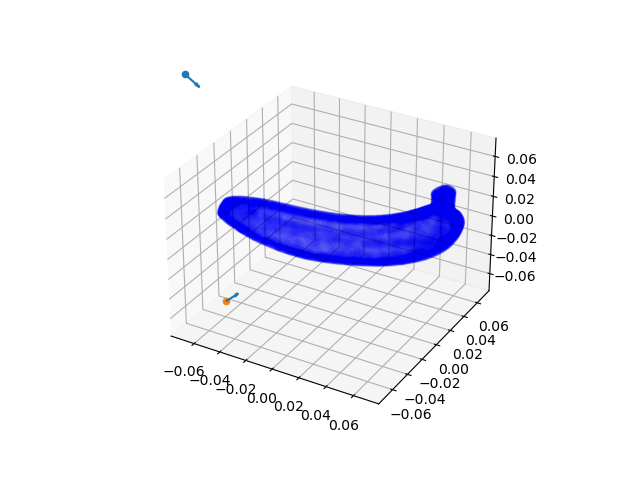

In [78]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

gps = np.load('grasp_data/banana.npy')

mu_np = gps[3]
rays_o, rays_d = torch.from_numpy(mu_np[:, :3]), torch.from_numpy(mu_np[:, 3:])

rays_d = grasp_utils.res_to_true_dirs(
            rays_o, rays_d, torch.from_numpy(gt_mesh.centroid).to(rays_o)
        )

for ii in range(rays_o.shape[0]):
    ax.scatter(rays_o[ii, 0], rays_o[ii, 1], rays_o[ii, 2])
    ax.quiver(*[rays_o[ii, jj] for jj in range(3)],
              *[rays_d[ii, jj] for jj in range(3)],
              length=0.015,
              normalize=True)

ax.scatter(*[gt_mesh.triangles_center[:, ii] for ii in range(3)],
           c='blue',
           alpha=0.025)

ax.set_xlim([-0.075, 0.075])
ax.set_ylim([-0.075, 0.075])
ax.set_zlim([-0.075, 0.075])


plt.show()

In [62]:
mesh_points, grad_ests, grasp_mask = mesh_utils.get_grasp_points(gt_mesh, grasp_points.reshape(1,3,6), True)

torch.Size([1, 3, 3]) torch.Size([1, 3, 3])


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [3, 4] but got: [3, 3].